References: <br>
https://github.com/bentrevett/pytorch-seq2seq <br>
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html<br>
Source Directory: https://www.statmt.org/europarl/ <br>
Data directory: https://drive.google.com/drive/folders/1Wwz0WPKWuc1RimMLze9klzAdRS-nGNw1?usp=sharing <br>
Please have all the files in the same folder for the code to execute

Importing the libraries: We use Pytorch to train our models

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.data import TabularDataset
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from spacy.lang.en import English
from spacy.lang.fr import French
from spacy.lang.es import Spanish
import numpy as np
import torch.nn.functional as F
import random
import math
import time
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu

Randomize the parameters for pytorch

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
device = 'cuda'

Loading the tokenizer and tokenizing the sentences <br>
Creating field values for the source, target1, target2 <br>
target1 represents spanish <br>
target2 represents French

In [0]:
spacy_en = English()
spacy_es = Spanish()
spacy_fr = French()

In [0]:
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_es(text):
    return [tok.text for tok in spacy_es.tokenizer(text)]

def tokenize_fr(text):
    return [tok.text for tok in spacy_fr.tokenizer(text)]

In [0]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG1 = Field(tokenize = tokenize_es, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG2 = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [0]:
tv_datafields = [("English", SRC),
                 ("Spanish", TRG1),
                 ("French", TRG2)]
trn, vld, tst = TabularDataset.splits(
               path = "./",
               train='train_df.csv', validation="val_df.csv", test="test_df.csv",
               format='csv',
               skip_header=True,
               fields=tv_datafields)

Building the vocabulary and creating batches for the model. <br>
We consider a batch size of 50

In [0]:
SRC.build_vocab(trn, min_freq = 2)
TRG1.build_vocab(trn, min_freq = 2)
TRG2.build_vocab(trn, min_freq = 2)

In [0]:
BATCH_SIZE = 50
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (trn, vld, tst),
     sort_key=lambda x: len(x.English),
     sort_within_batch=False,
     batch_size = BATCH_SIZE,
     device = device, 
     repeat=False)

Design of the network module:<br>
1) Encoder <br>
2) EncoderLayer <br>
3) MultiHeadedAttentionLayer <br>
4) PositionWiseEncoder <br> 
5) Decoder <br>
6) DecoderLayer<br>

In [0]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 400):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [0]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [0]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [0]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [0]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 400):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                       
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [0]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

Seq2Seq module <br>
Here we specify the sequence to sequence module flow. <br>
The encoded source goes into both the decoders, decoder1 and decoder2

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder1,
                 decoder2, 
                 src_pad_idx, 
                 trg1_pad_idx,
                 trg2_pad_idx,
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder1 = decoder1
        self.decoder2 = decoder2
        self.src_pad_idx = src_pad_idx
        self.trg1_pad_idx = trg1_pad_idx
        self.trg2_pad_idx = trg2_pad_idx,
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg1_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg1, trg2):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask1 = self.make_trg_mask(trg1)
        trg_mask2 = self.make_trg_mask(trg2)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src len, hid dim]
        output1, attention1 = self.decoder1(trg1, enc_src, trg_mask1, src_mask)
        output2, attention2 = self.decoder2(trg2, enc_src, trg_mask2, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output1, output2

Network Parameters<br>
Module block creation<br>

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM1 = len(TRG1.vocab)
OUTPUT_DIM2 = len(TRG2.vocab)
HID_DIM = 128
ENC_LAYERS = 1
DEC_LAYERS = 1
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 256
DEC_PF_DIM = 256
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec1 = Decoder(OUTPUT_DIM1, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

dec2 = Decoder(OUTPUT_DIM2,
               HID_DIM,
               DEC_LAYERS,
               DEC_HEADS,
               DEC_PF_DIM,
               DEC_DROPOUT,
               device)

SRC, TRG1, TRG2 vocab creation <br>
Initialize weights <br>
Optimizer: Adam optimizer<br>
Criterion: Cross Entropy<br>

In [0]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG1_PAD_IDX = TRG1.vocab.stoi[TRG1.pad_token]
TRG2_PAD_IDX = TRG2.vocab.stoi[TRG2.pad_token]

In [0]:
model = Seq2Seq(enc, dec1, dec2, SRC_PAD_IDX, TRG1_PAD_IDX, TRG2_PAD_IDX, device).to(device)

In [0]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [0]:
model.apply(initialize_weights);

In [0]:
LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG1_PAD_IDX)

The main idea behind this parallel model is derived from the loss propagation. <br>
In this case, we can have the loss being propagated from the network via two parallel paths, and hence we need to provide an additonal parameter saying retain_graph as true for the first loss we propagate. <br>

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss1 = 0
    epoch_loss2 = 0
    if len(iterator)==0:
      return None
    for i, batch in enumerate(iterator):
        loss1 = 0
        loss2 = 0
        src = batch.English
        trg1 = batch.Spanish
        trg2 = batch.French
        
        optimizer.zero_grad()
        
        output1, output2 = model(src, trg1[:,:-1], trg2[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim1 = output1.shape[-1]
        output_dim2 = output2.shape[-1]

        output1 = output1.contiguous().view(-1, output_dim1)
        output2 = output2.contiguous().view(-1, output_dim2)

        trg1 = trg1[:,1:].contiguous().view(-1)
        trg2 = trg2[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
           
        loss1 = criterion(output1, trg1)
        loss2 = criterion(output2, trg2)

        loss1.backward(retain_graph=True)
        loss2.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss1 += float(loss1)
        epoch_loss2 += float(loss2)
        
    return epoch_loss1 / len(iterator), epoch_loss2 / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Training loop

In [30]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss1, train_loss2 = train(model, train_iterator, optimizer, criterion, CLIP)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #if valid_loss < best_valid_loss:
        #best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss1: {train_loss1:.3f} | Train PPL: {math.exp(train_loss1):7.3f}')
    print(f'\tTrain Loss2: {train_loss2:.3f} | Train PPL: {math.exp(train_loss2):7.3f}')
torch.save(model.state_dict(), 'transformer-model.pt')

Epoch: 01 | Time: 1m 7s
	Train Loss1: 4.548 | Train PPL:  94.404
	Train Loss2: 4.492 | Train PPL:  89.343
Epoch: 02 | Time: 1m 6s
	Train Loss1: 3.193 | Train PPL:  24.363
	Train Loss2: 3.183 | Train PPL:  24.116
Epoch: 03 | Time: 1m 6s
	Train Loss1: 2.702 | Train PPL:  14.915
	Train Loss2: 2.723 | Train PPL:  15.226
Epoch: 04 | Time: 1m 6s
	Train Loss1: 2.421 | Train PPL:  11.260
	Train Loss2: 2.461 | Train PPL:  11.712
Epoch: 05 | Time: 1m 6s
	Train Loss1: 2.230 | Train PPL:   9.299
	Train Loss2: 2.283 | Train PPL:   9.805
Epoch: 06 | Time: 1m 6s
	Train Loss1: 2.094 | Train PPL:   8.114
	Train Loss2: 2.156 | Train PPL:   8.638
Epoch: 07 | Time: 1m 6s
	Train Loss1: 1.988 | Train PPL:   7.301
	Train Loss2: 2.058 | Train PPL:   7.834
Epoch: 08 | Time: 1m 6s
	Train Loss1: 1.904 | Train PPL:   6.714
	Train Loss2: 1.981 | Train PPL:   7.249
Epoch: 09 | Time: 1m 6s
	Train Loss1: 1.839 | Train PPL:   6.292
	Train Loss2: 1.916 | Train PPL:   6.792
Epoch: 10 | Time: 1m 6s
	Train Loss1: 1.780 | 

In [0]:
model_loaded = model.load_state_dict(torch.load('transformer-model.pt'))

In [32]:
model_loaded

<All keys matched successfully>

The inference model, for translating the sentences. <br>
This is similar to the seq2seq module except the back propagation

In [0]:
def translate_sentence(sentence, src_field, trg_field1, trg_field2, model, device, max_len = 400):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes1 = [trg_field1.vocab.stoi[trg_field1.init_token]]
    trg_indexes2 = [trg_field2.vocab.stoi[trg_field2.init_token]]

    for i in range(max_len):

        trg_tensor1 = torch.LongTensor(trg_indexes1).unsqueeze(0).to(device)

        trg_mask1 = model.make_trg_mask(trg_tensor1)
        
        with torch.no_grad():
            output1, attention1 = model.decoder1(trg_tensor1, enc_src, trg_mask1, src_mask)
        
        pred_token1 = output1.argmax(2)[:,-1].item()

        trg_indexes1.append(pred_token1)

        if pred_token1 == trg_field1.vocab.stoi[trg_field1.eos_token]:
            break
    
    trg_tokens1 = [trg_field1.vocab.itos[i] for i in trg_indexes1]

    for i in range(max_len):

        trg_tensor2 = torch.LongTensor(trg_indexes2).unsqueeze(0).to(device)

        trg_mask2 = model.make_trg_mask(trg_tensor2)
        
        with torch.no_grad():
            output2, attention2 = model.decoder2(trg_tensor2, enc_src, trg_mask2, src_mask)
        
        pred_token2 = output2.argmax(2)[:,-1].item()

        trg_indexes2.append(pred_token2)

        if pred_token2 == trg_field2.vocab.stoi[trg_field2.eos_token]:
            break
    
    trg_tokens2 = [trg_field2.vocab.itos[i] for i in trg_indexes2]
    
    return trg_tokens1[1:], attention1, trg_tokens2[1:], attention2

Checking the output for a random index

In [41]:
example_idx = 25

src = vars(tst.examples[example_idx])['English']
trg1 = vars(tst.examples[example_idx])['Spanish']
trg2 = vars(tst.examples[example_idx])['French']
s =" "

print(f'src = {s.join(src)}')
print(f'trg1 = {s.join(trg1)}')
print(f'trg2 = {s.join(trg2)}')

src = i have three very specific questions .
trg1 = tengo tres preguntas muy específicas .
trg2 = j' ai trois questions très concrètes .


In [42]:
translation1, attention1, translation2, attention2 = translate_sentence(src, SRC, TRG1, TRG2, model, device)
s = " "
print(f'predicted trg1 = {s.join(translation1)}')
print(f'predicted trg2 = {s.join(translation2)}')

predicted trg1 = he tenido tres preguntas muy específicas . <eos>
predicted trg2 = j' ai trois questions très spécifiques . <eos>


The attention model heatmap to visualize the learnt translation

In [0]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

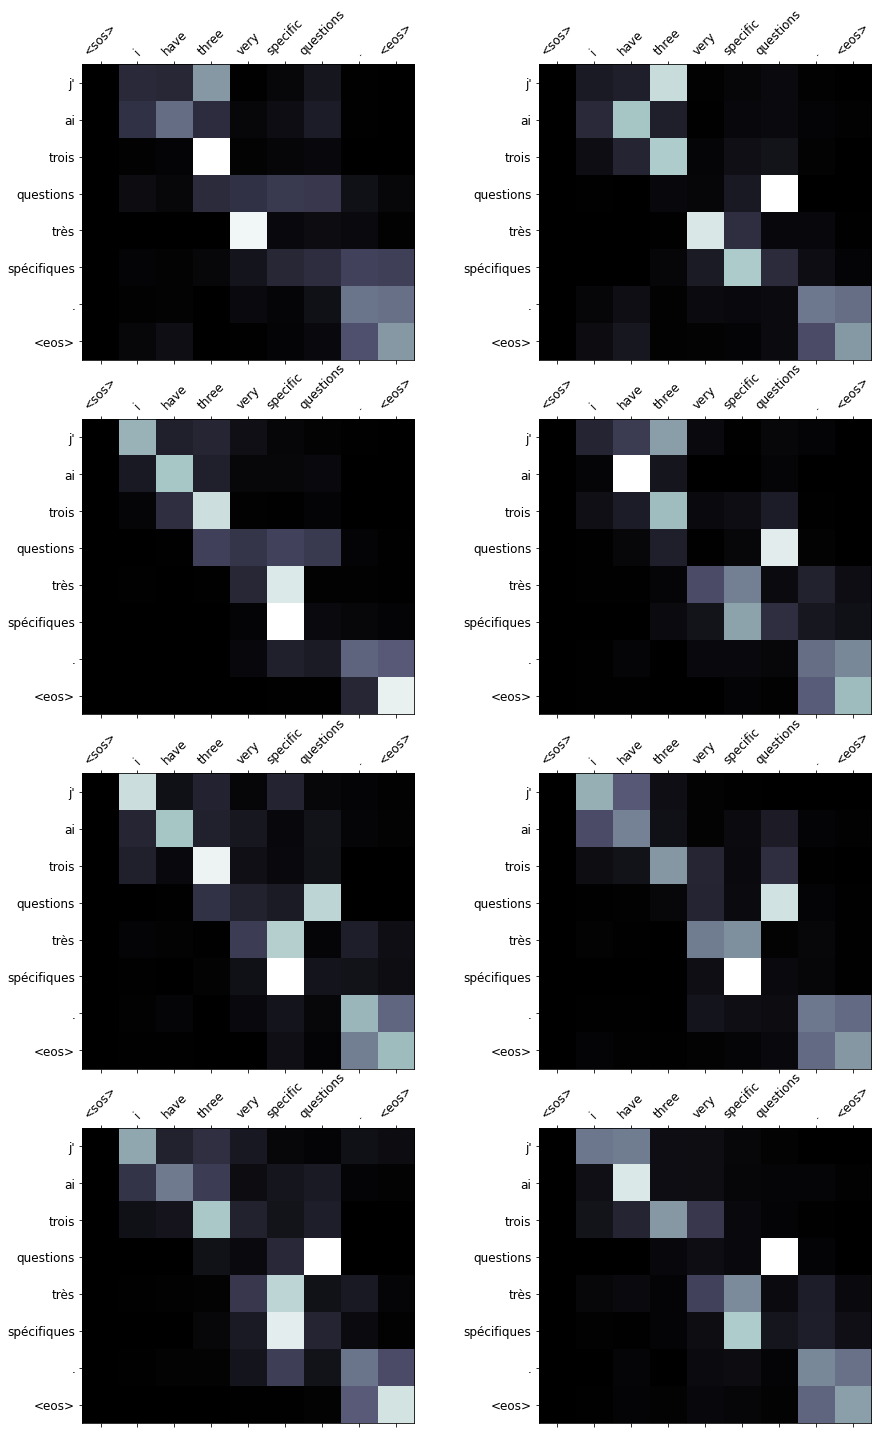

In [45]:
translation1, attention1, translation2, attention2 = translate_sentence(src, SRC, TRG1, TRG2, model, device)
display_attention(src, translation2, attention2)

Calculating the BLEU score

In [0]:
def calculate_bleu(data, src_field, trg_field1, trg_field2, model, device, max_len = 400):
    count=0
    bleu1=0
    bleu2=0
    for datum in data:
        count+=1
        src = vars(datum)['English']
        trg1 = vars(datum)['Spanish']
        trg2 = vars(datum)['French']
        
        pred_trg1, _, pred_trg2, _ = translate_sentence(src, src_field, trg_field1, trg_field2, model, device, max_len)
        
        #cut off <eos> token
        pred_trg1 = pred_trg1[:-1]
        pred_trg2 = pred_trg2[:-1]
        bleu1 += sentence_bleu([pred_trg1], trg1)
        bleu2 += sentence_bleu([pred_trg2], trg2)
    return bleu1/count, bleu2/count

In [0]:
bleu_score1, bleu_score2 = calculate_bleu(tst, SRC, TRG1, TRG2, model, device)
print(f'BLEU score = {bleu_score1*100:.2f}, {bleu_score2*100:.2f}')